In [1]:
import numpy as np
import pandas as pd 
import os
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
base_path = "rice_leaf_diseases"

# EDA of Rice Leaf

In [3]:
class_names = os.listdir(base_path)
print("Classes found:", class_names)

Classes found: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


## Count images per class

In [4]:
image_counts = {}
image_paths = {}

C:\Users\ppmis\AppData\Local\Temp\ipykernel_23136\2172703209.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="Set2")


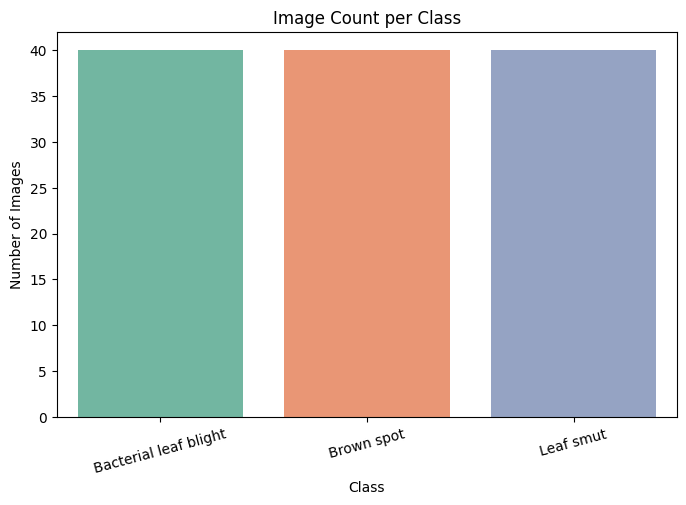

In [5]:
for cls in class_names:
    class_dir = os.path.join(base_path, cls)
    images = glob(os.path.join(class_dir, "*.jpg"))
    image_counts[cls] = len(images)
    image_paths[cls] = images


plt.figure(figsize=(8,5))
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()), palette="Set2")
plt.title("Image Count per Class")
plt.ylabel("Number of Images")
plt.xlabel("Class")
plt.xticks(rotation=15)
plt.show()

## Display few sample images from each class

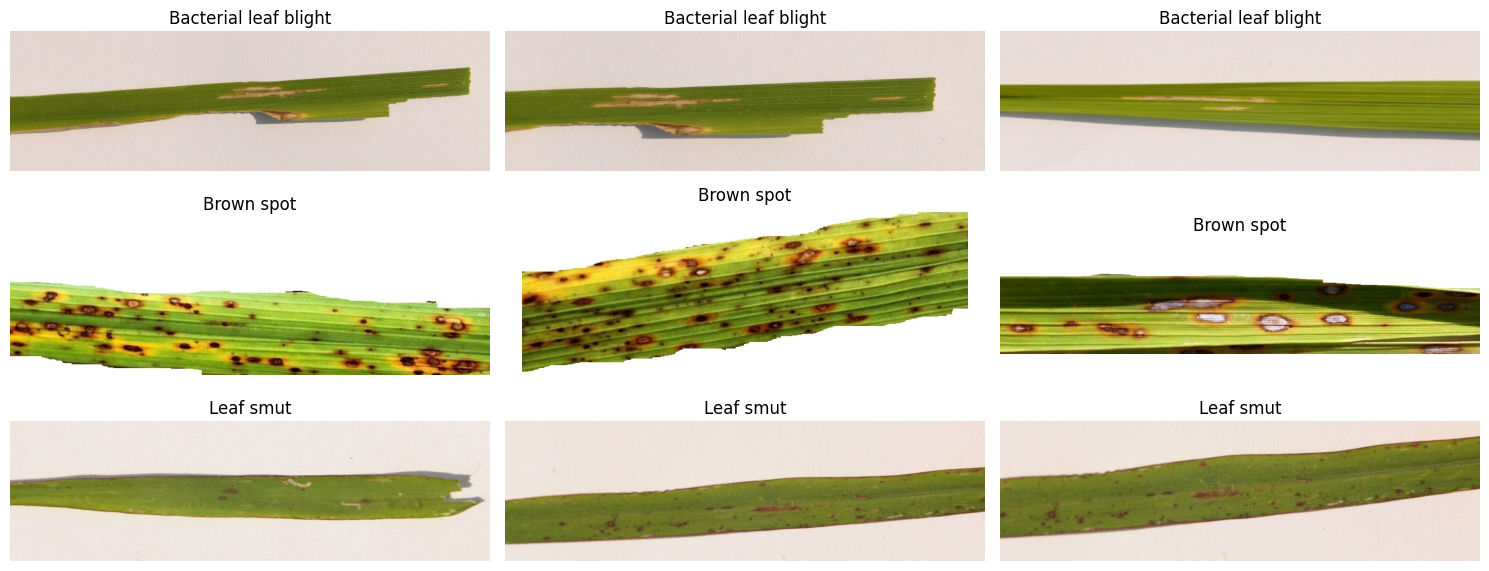

In [6]:
def show_sample_images(image_paths, class_names, num_images=3):
    plt.figure(figsize=(15, 6))
    for idx, cls in enumerate(class_names):
        for i in range(num_images):
            img_path = image_paths[cls][i]
            img = Image.open(img_path)
            plt.subplot(len(class_names), num_images, idx*num_images + i + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

show_sample_images(image_paths, class_names)

## Analyze image sizes

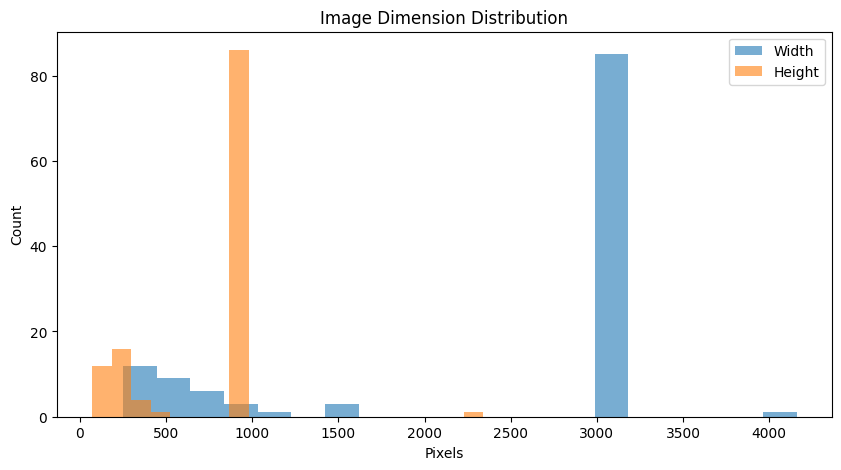

In [7]:
image_sizes = []
for cls in class_names:
    for path in image_paths[cls][:100]:  
        img = Image.open(path)
        image_sizes.append(img.size)

widths, heights = zip(*image_sizes)
plt.figure(figsize=(10, 5))
plt.hist(widths, bins=20, alpha=0.6, label='Width')
plt.hist(heights, bins=20, alpha=0.6, label='Height')
plt.title("Image Dimension Distribution")
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.legend()
plt.show()

## Summary stats

In [8]:

print("Number of classes:", len(class_names))
print("Total images:", sum(image_counts.values()))
print("Sample image size (WxH):", image_sizes[0])

Number of classes: 3
Total images: 120
Sample image size (WxH): (3081, 897)


# CNN Model Build 

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os

## Parameters

In [10]:
img_size = (128, 128)
batch_size = 32

## Image preprocessing

In [11]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_gen = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 96 images belonging to 3 classes.
Found 24 images belonging to 3 classes.


In [12]:

print("Class indices:", train_gen.class_indices)

Class indices: {'Bacterial leaf blight': 0, 'Brown spot': 1, 'Leaf smut': 2}


In [13]:

from tensorflow.keras import Input

model = models.Sequential([
    Input(shape=(img_size[0], img_size[1], 3)), 

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:

history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)

C:\Users\ppmis\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 631ms/step - accuracy: 0.3828 - loss: 1.2484 - val_accuracy: 0.3333 - val_loss: 1.1446
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step - accuracy: 0.2930 - loss: 1.1634 - val_accuracy: 0.3750 - val_loss: 1.0866
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - accuracy: 0.4531 - loss: 1.0799 - val_accuracy: 0.3750 - val_loss: 1.0355
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 533ms/step - accuracy: 0.5208 - loss: 1.0216 - val_accuracy: 0.5833 - val_loss: 0.9779
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step - accuracy: 0.5469 - loss: 1.0025 - val_accuracy: 0.3750 - val_loss: 0.9517
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 525ms/step - accuracy: 0.5612 - loss: 0.9314 - val_accuracy: 0.7083 - val_loss: 0.7781
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 462ms/step - accuracy: 0.6693 - loss: 0.8088 - val_accuracy: 0.7500 - val_loss: 0.7004
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step - accuracy: 0.7057 - loss: 0.7196 - val_accuracy: 0.7917 - val_loss:

In [15]:

loss, acc = model.evaluate(val_gen)
print(f"\n✅ Validation Accuracy: {acc:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6250 - loss: 0.7359

✅ Validation Accuracy: 0.62


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Input
import os

In [17]:

val_gen.reset()
predictions = model.predict(val_gen, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = val_gen.classes
class_names = list(val_gen.class_indices.keys())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


In [18]:

cm = confusion_matrix(y_true, y_pred)

In [19]:

def plot_history(hist):
    plt.figure(figsize=(12, 5))
    

    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'], label='Train Accuracy')
    plt.plot(hist.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [20]:

def plot_conf_matrix(cm, classes):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [23]:

model.save('rice_leaf_disease_model.h5')

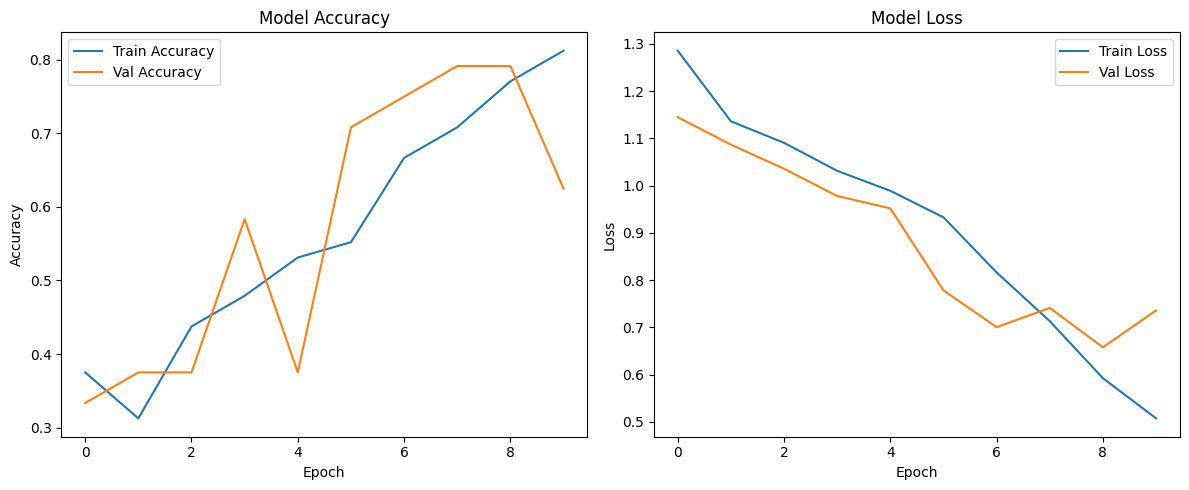

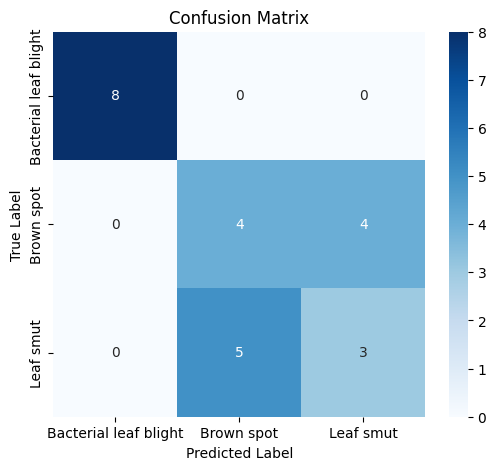

In [24]:

plot_history(history)
plot_conf_matrix(cm, class_names)